In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import pickle
import random
import importlib
import sys

import shap
from pdpbox import pdp
import matplotlib.pyplot as plt
import japanize_matplotlib

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import common

# モジュールの再読み込み
importlib.reload(common)

_common = common.Common()
_common.BASE_PATH

PosixPath('/Users/iwasakitakahiro/github')

In [3]:
common_func_path = _common.COMMON_FUNC_PATH
sys.path.append(str(common_func_path))

import func

importlib.reload(func)

<module 'func' from '/Users/iwasakitakahiro/github/共通関数/func.py'>

In [4]:
train_df = pd.read_csv('../output/中間データ/学習用データ/train_preprocessed.csv')
train_df.head()

,time,total_load_actual,price_actual,gene_sum,sus_rate,fossil_rate,gene_load_ratio,gene_cost,residual_demand,residual_demand_ratio,...,weighted_temp,weighted_pressure,weighted_humidity,weighted_clouds_all,encoded_price_weekday_hour,valencia_weather_main_LabelEn,madrid_weather_main_LabelEn,bilbao_weather_main_LabelEn,barcelona_weather_main_LabelEn,seville_weather_main_LabelEn
0,2015-01-04 23:00:00+00:00,25254.0,70.77,28411.0,0.463694,0.241561,1.125010,1548420.0,12080.0,0.478340,...,276.967912,1015.043896,80.887517,0.547325,54.098571,1,1,3,1,1
1,2015-01-05 00:00:00+00:00,23620.0,64.89,28181.0,0.444768,0.250594,1.193099,1530340.0,11086.0,0.469348,...,276.820726,999.486283,70.303155,0.312757,50.789231,1,1,2,1,1
2,2015-01-05 01:00:00+00:00,22606.0,60.91,27454.0,0.427114,0.246631,1.214456,1466040.0,10880.0,0.481288,...,276.582165,999.434842,70.622085,2.602195,47.007692,1,1,2,1,2
3,2015-01-05 02:00:00+00:00,22191.0,59.68,27243.0,0.421760,0.237162,1.227660,1431815.0,10701.0,0.482223,...,275.754675,998.938957,73.982853,2.419753,44.716154,1,1,1,1,2
4,2015-01-05 03:00:00+00:00,21929.0,58.04,26898.0,0.425645,0.220611,1.226595,1391665.0,10480.0,0.477906,...,275.712079,998.548011,74.373800,2.784636,43.612308,1,1,2,1,2


In [5]:
X_train = train_df.drop(columns=[_common.TARGET_COL, _common.UNIQUE_KEY_COLS])
y_train = train_df[_common.TARGET_COL]

In [6]:
# 再現性確保のための固定シード
SEED = 1234
random.seed(SEED)
np.random.seed(SEED)

# Optunaのシードも固定
sampler = optuna.samplers.TPESampler(seed=SEED)

# LightGBMにも同様に
default_params = {
    'objective': 'regression_l2',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'random_state': SEED,
    'verbosity': -1
}

In [7]:
tscv = TimeSeriesSplit(n_splits=5)

#### ハイパーパラメータチューニング

In [8]:
# 最適化の対象関数
def objective(trial):
    return func.run_optuna(
        trial=trial,
        features=X_train,         # 特徴量データフレーム
        target=y_train,           # 目的変数
        cv_strategy=tscv,         # ← partition_col → cv_strategy に変更済み
        model_name='lgb',
        default_columns=default_params,
        metric='rmse',
        random_seed=SEED
    )

# Optuna スタディの作成・実行
study = optuna.create_study(
    direction='minimize',
    sampler=optuna.samplers.TPESampler(seed=SEED)
)
study.optimize(objective, n_trials=50, timeout=1800)

# 最良トライアルの結果
trial = study.best_trial
lgb_params = default_params | trial.params  # Python 3.9以降

# 結果の表示
print('Best trial:')
print(f'RMSE: {trial.value:.4f}')
print('Params:')
for key, value in trial.params.items():
    print(f'{key}: {value}')

[I 2025-06-12 08:10:24,273] A new study created in memory with name: no-name-8175e475-cac4-46c2-bb80-80b21cadff7b


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[67]	valid_0's rmse: 9.20877
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[441]	valid_0's rmse: 20.5423
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[53]	valid_0's rmse: 9.17042
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[36]	valid_0's rmse: 12.8969
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:10:33,585] Trial 0 finished with value: 11.724427568215152 and parameters: {'learning_rate': 0.015542448978618607, 'num_leaves': 74, 'feature_fraction': 0.8875455478014229, 'bagging_fraction': 0.9570717167427538, 'bagging_freq': 8}. Best is trial 0 with value: 11.724427568215152.


Early stopping, best iteration is:
[209]	valid_0's rmse: 6.80377
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[66]	valid_0's rmse: 9.30976
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[420]	valid_0's rmse: 20.4082
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[47]	valid_0's rmse: 9.218
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 12.734
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:10:40,120] Trial 1 finished with value: 11.679915135416646 and parameters: {'learning_rate': 0.01873236473539007, 'num_leaves': 50, 'feature_fraction': 0.9603744355070039, 'bagging_fraction': 0.991627870736741, 'bagging_freq': 9}. Best is trial 1 with value: 11.679915135416646.


Early stopping, best iteration is:
[225]	valid_0's rmse: 6.72962
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[52]	valid_0's rmse: 9.28618
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[340]	valid_0's rmse: 20.5229
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 9.31221
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	valid_0's rmse: 12.8218
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:10:46,810] Trial 2 finished with value: 11.744625158103059 and parameters: {'learning_rate': 0.02279382816537334, 'num_leaves': 66, 'feature_fraction': 0.9366925870344273, 'bagging_fraction': 0.94254040539658, 'bagging_freq': 4}. Best is trial 1 with value: 11.679915135416646.


Early stopping, best iteration is:
[167]	valid_0's rmse: 6.77999
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 9.10549
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[325]	valid_0's rmse: 20.3156
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 9.19245
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[15]	valid_0's rmse: 12.855
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:10:52,229] Trial 3 finished with value: 11.640373972387058 and parameters: {'learning_rate': 0.036407946646282316, 'num_leaves': 66, 'feature_fraction': 0.8027536899181364, 'bagging_fraction': 0.9545653243224748, 'bagging_freq': 9}. Best is trial 3 with value: 11.640373972387058.


Early stopping, best iteration is:
[105]	valid_0's rmse: 6.73332
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[49]	valid_0's rmse: 9.00085
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[236]	valid_0's rmse: 20.4717
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	valid_0's rmse: 9.26938
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12.789
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:10:58,756] Trial 4 finished with value: 11.652245220509052 and parameters: {'learning_rate': 0.02316786340105235, 'num_leaves': 74, 'feature_fraction': 0.8150762483285954, 'bagging_fraction': 0.8737648012003949, 'bagging_freq': 10}. Best is trial 3 with value: 11.640373972387058.


Early stopping, best iteration is:
[155]	valid_0's rmse: 6.73036
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 9.21413
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[148]	valid_0's rmse: 20.5169
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid_0's rmse: 9.20776
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 12.7851
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:02,431] Trial 5 finished with value: 11.716668689907687 and parameters: {'learning_rate': 0.04481033010266881, 'num_leaves': 58, 'feature_fraction': 0.9577460285881492, 'bagging_fraction': 0.8633672244337742, 'bagging_freq': 6}. Best is trial 3 with value: 11.640373972387058.


Early stopping, best iteration is:
[88]	valid_0's rmse: 6.8595
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 9.32438
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:03,089] Trial 6 pruned. Trial was pruned at iteration 48.
[I 2025-06-12 08:11:03,235] Trial 7 pruned. Trial was pruned at iteration 24.
[I 2025-06-12 08:11:03,252] Trial 8 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:03,358] Trial 9 pruned. Trial was pruned at iteration 22.


Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:03,639] Trial 10 pruned. Trial was pruned at iteration 26.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[45]	valid_0's rmse: 9.07151
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[361]	valid_0's rmse: 20.4069
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[35]	valid_0's rmse: 9.27934
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 12.8393
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:11,138] Trial 11 finished with value: 11.68699314844572 and parameters: {'learning_rate': 0.028192493078093264, 'num_leaves': 81, 'feature_fraction': 0.8013875389644363, 'bagging_fraction': 0.9124332327724473, 'bagging_freq': 10}. Best is trial 3 with value: 11.640373972387058.


Early stopping, best iteration is:
[93]	valid_0's rmse: 6.838
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 8.98465
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[297]	valid_0's rmse: 20.2782
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[25]	valid_0's rmse: 9.18548
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 12.9418
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:17,679] Trial 12 finished with value: 11.618390791166753 and parameters: {'learning_rate': 0.03455716795434382, 'num_leaves': 84, 'feature_fraction': 0.8410064845495937, 'bagging_fraction': 0.805494736185089, 'bagging_freq': 8}. Best is trial 12 with value: 11.618390791166753.


Early stopping, best iteration is:
[102]	valid_0's rmse: 6.7018
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 9.0039
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[144]	valid_0's rmse: 20.3146
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 9.07933
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 12.9296
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:23,035] Trial 13 finished with value: 11.618244183428628 and parameters: {'learning_rate': 0.043460733681057295, 'num_leaves': 99, 'feature_fraction': 0.8457261570880235, 'bagging_fraction': 0.8007817770736659, 'bagging_freq': 8}. Best is trial 13 with value: 11.618244183428628.


Early stopping, best iteration is:
[78]	valid_0's rmse: 6.76379
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.00897
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 20.3353
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.25621
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 12.9105
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:27,681] Trial 14 finished with value: 11.656446821691054 and parameters: {'learning_rate': 0.06417286992101286, 'num_leaves': 100, 'feature_fraction': 0.8474595636409968, 'bagging_fraction': 0.8013813484537643, 'bagging_freq': 7}. Best is trial 13 with value: 11.618244183428628.


Early stopping, best iteration is:
[56]	valid_0's rmse: 6.77119
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.05516
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[248]	valid_0's rmse: 20.3297
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 9.19455
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 12.9338
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:33,089] Trial 15 finished with value: 11.665278882995079 and parameters: {'learning_rate': 0.052806612093222044, 'num_leaves': 88, 'feature_fraction': 0.8475589051116365, 'bagging_fraction': 0.8060965515366897, 'bagging_freq': 4}. Best is trial 13 with value: 11.618244183428628.


Early stopping, best iteration is:
[64]	valid_0's rmse: 6.81317
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[24]	valid_0's rmse: 9.09312
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[201]	valid_0's rmse: 20.4617
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 9.22514
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 12.7675
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:38,529] Trial 16 finished with value: 11.670533618599036 and parameters: {'learning_rate': 0.03978302281856687, 'num_leaves': 87, 'feature_fraction': 0.8799932677464333, 'bagging_fraction': 0.8356814263709003, 'bagging_freq': 8}. Best is trial 13 with value: 11.618244183428628.
[I 2025-06-12 08:11:38,559] Trial 17 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[77]	valid_0's rmse: 6.80524
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:38,846] Trial 18 pruned. Trial was pruned at iteration 30.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 8.97616
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[84]	valid_0's rmse: 20.5181
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[9]	valid_0's rmse: 9.40411
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[6]	valid_0's rmse: 12.7151
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:41,693] Trial 19 finished with value: 11.693540791957968 and parameters: {'learning_rate': 0.09902292356250053, 'num_leaves': 77, 'feature_fraction': 0.8349186857488646, 'bagging_fraction': 0.8532091309057607, 'bagging_freq': 1}. Best is trial 13 with value: 11.618244183428628.
[I 2025-06-12 08:11:41,722] Trial 20 pruned. Trial was pruned at iteration 0.
[I 2025-06-12 08:11:41,792] Trial 21 pruned. Trial was pruned at iteration 6.
[I 2025-06-12 08:11:41,825] Trial 22 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[34]	valid_0's rmse: 6.85423
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[32]	valid_0's rmse: 9.17108
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[211]	valid_0's rmse: 20.4722
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 9.26195
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 12.7472
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:45,412] Trial 23 finished with value: 11.68474712850958 and parameters: {'learning_rate': 0.04415277522280265, 'num_leaves': 54, 'feature_fraction': 0.8647876596473892, 'bagging_fraction': 0.9230345550075019, 'bagging_freq': 7}. Best is trial 13 with value: 11.618244183428628.
[I 2025-06-12 08:11:45,442] Trial 24 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[62]	valid_0's rmse: 6.77133
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[27]	valid_0's rmse: 9.08541
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[162]	valid_0's rmse: 20.3134
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 9.28204
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 12.7993
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:49,516] Trial 25 finished with value: 11.65037689113888 and parameters: {'learning_rate': 0.04885067248261405, 'num_leaves': 71, 'feature_fraction': 0.8208415768327186, 'bagging_fraction': 0.8472061602510141, 'bagging_freq': 9}. Best is trial 13 with value: 11.618244183428628.
[I 2025-06-12 08:11:49,562] Trial 26 pruned. Trial was pruned at iteration 2.


Early stopping, best iteration is:
[64]	valid_0's rmse: 6.77181
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:49,768] Trial 27 pruned. Trial was pruned at iteration 19.
[I 2025-06-12 08:11:49,798] Trial 28 pruned. Trial was pruned at iteration 0.
[I 2025-06-12 08:11:49,825] Trial 29 pruned. Trial was pruned at iteration 0.
[I 2025-06-12 08:11:49,853] Trial 30 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	valid_0's rmse: 9.15433
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[225]	valid_0's rmse: 20.5407
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.25571
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 12.8223
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:54,259] Trial 31 finished with value: 11.71144448465874 and parameters: {'learning_rate': 0.04704472622405901, 'num_leaves': 70, 'feature_fraction': 0.8199774469895866, 'bagging_fraction': 0.8517191317047826, 'bagging_freq': 9}. Best is trial 13 with value: 11.618244183428628.
[I 2025-06-12 08:11:54,288] Trial 32 pruned. Trial was pruned at iteration 0.
[I 2025-06-12 08:11:54,318] Trial 33 pruned. Trial was pruned at iteration 0.
[I 2025-06-12 08:11:54,344] Trial 34 pruned. Trial was pruned at iteration 0.


Early stopping, best iteration is:
[68]	valid_0's rmse: 6.7842
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[29]	valid_0's rmse: 9.16768
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[249]	valid_0's rmse: 20.1439
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[18]	valid_0's rmse: 9.16454
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 12.7415
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:11:58,415] Trial 35 finished with value: 11.607419982874399 and parameters: {'learning_rate': 0.05246818214311594, 'num_leaves': 64, 'feature_fraction': 0.8234894456832036, 'bagging_fraction': 0.8094997369988877, 'bagging_freq': 10}. Best is trial 35 with value: 11.607419982874399.
[I 2025-06-12 08:11:58,524] Trial 36 pruned. Trial was pruned at iteration 14.


Early stopping, best iteration is:
[51]	valid_0's rmse: 6.81952
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.09821
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[149]	valid_0's rmse: 20.2276
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[14]	valid_0's rmse: 9.31662
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 12.7451
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:12:01,872] Trial 37 finished with value: 11.639626682786169 and parameters: {'learning_rate': 0.05690858709571249, 'num_leaves': 63, 'feature_fraction': 0.8510858179417828, 'bagging_fraction': 0.8095864541528838, 'bagging_freq': 10}. Best is trial 35 with value: 11.607419982874399.


Early stopping, best iteration is:
[61]	valid_0's rmse: 6.81053
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.02403
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[107]	valid_0's rmse: 20.6046
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 9.26568
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 12.6081
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:12:04,739] Trial 38 finished with value: 11.681138520862744 and parameters: {'learning_rate': 0.07467277609493632, 'num_leaves': 65, 'feature_fraction': 0.8518109679389787, 'bagging_fraction': 0.8328515312727227, 'bagging_freq': 10}. Best is trial 35 with value: 11.607419982874399.
[I 2025-06-12 08:12:04,877] Trial 39 pruned. Trial was pruned at iteration 18.


Early stopping, best iteration is:
[38]	valid_0's rmse: 6.90327
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:12:04,969] Trial 40 pruned. Trial was pruned at iteration 12.
[I 2025-06-12 08:12:04,997] Trial 41 pruned. Trial was pruned at iteration 0.


Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[31]	valid_0's rmse: 9.06677
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[180]	valid_0's rmse: 20.3333
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.31555
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	valid_0's rmse: 12.7278
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:12:08,687] Trial 42 finished with value: 11.625400277914306 and parameters: {'learning_rate': 0.05056898803445079, 'num_leaves': 58, 'feature_fraction': 0.8121852214695184, 'bagging_fraction': 0.8385183928866146, 'bagging_freq': 10}. Best is trial 35 with value: 11.607419982874399.
[I 2025-06-12 08:12:08,793] Trial 43 pruned. Trial was pruned at iteration 15.


Early stopping, best iteration is:
[87]	valid_0's rmse: 6.68363
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.06562
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[145]	valid_0's rmse: 20.4204
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 9.29956
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[10]	valid_0's rmse: 12.505
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:12:11,935] Trial 44 finished with value: 11.609251515784255 and parameters: {'learning_rate': 0.06361562964147131, 'num_leaves': 58, 'feature_fraction': 0.8595832903818026, 'bagging_fraction': 0.8264823178209322, 'bagging_freq': 10}. Best is trial 35 with value: 11.607419982874399.


Early stopping, best iteration is:
[63]	valid_0's rmse: 6.75569
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[17]	valid_0's rmse: 9.07046
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[115]	valid_0's rmse: 20.2876
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[12]	valid_0's rmse: 9.27355
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 12.6078
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:12:14,607] Trial 45 finished with value: 11.615168097567024 and parameters: {'learning_rate': 0.06875239086301747, 'num_leaves': 57, 'feature_fraction': 0.8113870202657362, 'bagging_fraction': 0.8266370126281216, 'bagging_freq': 9}. Best is trial 35 with value: 11.607419982874399.
[I 2025-06-12 08:12:14,699] Trial 46 pruned. Trial was pruned at iteration 14.
[I 2025-06-12 08:12:14,796] Trial 47 pruned. Trial was pruned at iteration 12.


Early stopping, best iteration is:
[46]	valid_0's rmse: 6.83645
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 9.00954
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[126]	valid_0's rmse: 20.2606
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	valid_0's rmse: 9.37875
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[8]	valid_0's rmse: 12.6566
Training until validation scores don't improve for 30 rounds


[I 2025-06-12 08:12:17,249] Trial 48 finished with value: 11.638039148578745 and parameters: {'learning_rate': 0.07554898806304369, 'num_leaves': 53, 'feature_fraction': 0.8231263402511586, 'bagging_fraction': 0.8191246645416231, 'bagging_freq': 7}. Best is trial 35 with value: 11.607419982874399.
[I 2025-06-12 08:12:17,415] Trial 49 pruned. Trial was pruned at iteration 21.


Early stopping, best iteration is:
[34]	valid_0's rmse: 6.88465
Training until validation scores don't improve for 30 rounds
Best trial:
RMSE: 11.6074
Params:
learning_rate: 0.05246818214311594
num_leaves: 64
feature_fraction: 0.8234894456832036
bagging_fraction: 0.8094997369988877
bagging_freq: 10


#### 全データで学習

In [9]:
# LightGBM Dataset の作成
lgb_train = lgb.Dataset(X_train, label=y_train)

callbacks = [
    lgb.log_evaluation(period=50)
]

# モデルの再学習（最終学習）
final_model = lgb.train(
    lgb_params,
    train_set=lgb_train,
    callbacks=callbacks,
)

# トレーニングデータで予測
y_train_pred = final_model.predict(X_train)

# RMSEを計算
final_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))

print(f"LightGBMのトレーニングRMSE: {final_rmse:.4f}")

LightGBMのトレーニングRMSE: 4.0499


In [10]:
# 保存用のディクショナリにまとめる
model_package = {
    'model': final_model,
    'feature_name': X_train.columns.tolist()
}

# 保存
with open('../output/モデル/lgb_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

#### 特徴量重要度

In [11]:
shap_sample = X_train.sample(n=100, random_state=1234)

In [12]:
# shap値の取得
def get_shap_value(model, shap_sample, model_type, masker_data=None):
    if model_type == 'tree':
        explainer =shap.TreeExplainer(model, feature_perturbation='tree_path_dependent', model_output='raw')
    shap_values = explainer.shap_values(shap_sample)
    shap_values = np.array(shap_values, dtype=np.float64)

    return shap_values

# 重要特徴量の計算
def compute_shap_importance(shap_values, shap_sample):
    if isinstance(shap_values, list):
        shap_array = np.abs(shap_values[0])
    elif hasattr(shap_values, 'values'):
        shap_array = np.abs(shap_values.values)
    else:
        shap_array = np.abs(shap_values)
    
    shap_importance = pd.DataFrame({
        '特徴量': shap_sample.columns,
        '特徴量の重要度': shap_array.mean(axis=0)
    }).sort_values(by='特徴量の重要度', ascending=False)

    max_importance = shap_importance['特徴量の重要度'].max()
    shap_importance['特徴量の相対的重要度'] = shap_importance['特徴量の重要度'] / max_importance

    display(shap_importance.head(100))

    return shap_importance

In [13]:
shap_values = get_shap_value(final_model, shap_sample, 'tree', masker_data=None)
shap_importance = compute_shap_importance(shap_values, shap_sample)

,特徴量,特徴量の重要度,特徴量の相対的重要度
32,encoded_price_weekday_hour,6.876594,1.000000
19,gene_sum_rolling_mean672,2.132808,0.310155
27,weighted_wind_speed,1.807043,0.262782
3,fossil_rate,1.593337,0.231704
12,month,0.838705,0.121965
26,total_load_actual_rolling_mean672,0.808960,0.117640
17,gene_sum_rolling_mean168,0.800158,0.116360
5,gene_cost,0.660982,0.096121
29,weighted_pressure,0.652452,0.094880
24,total_load_actual_rolling_mean168,0.591413,0.086004


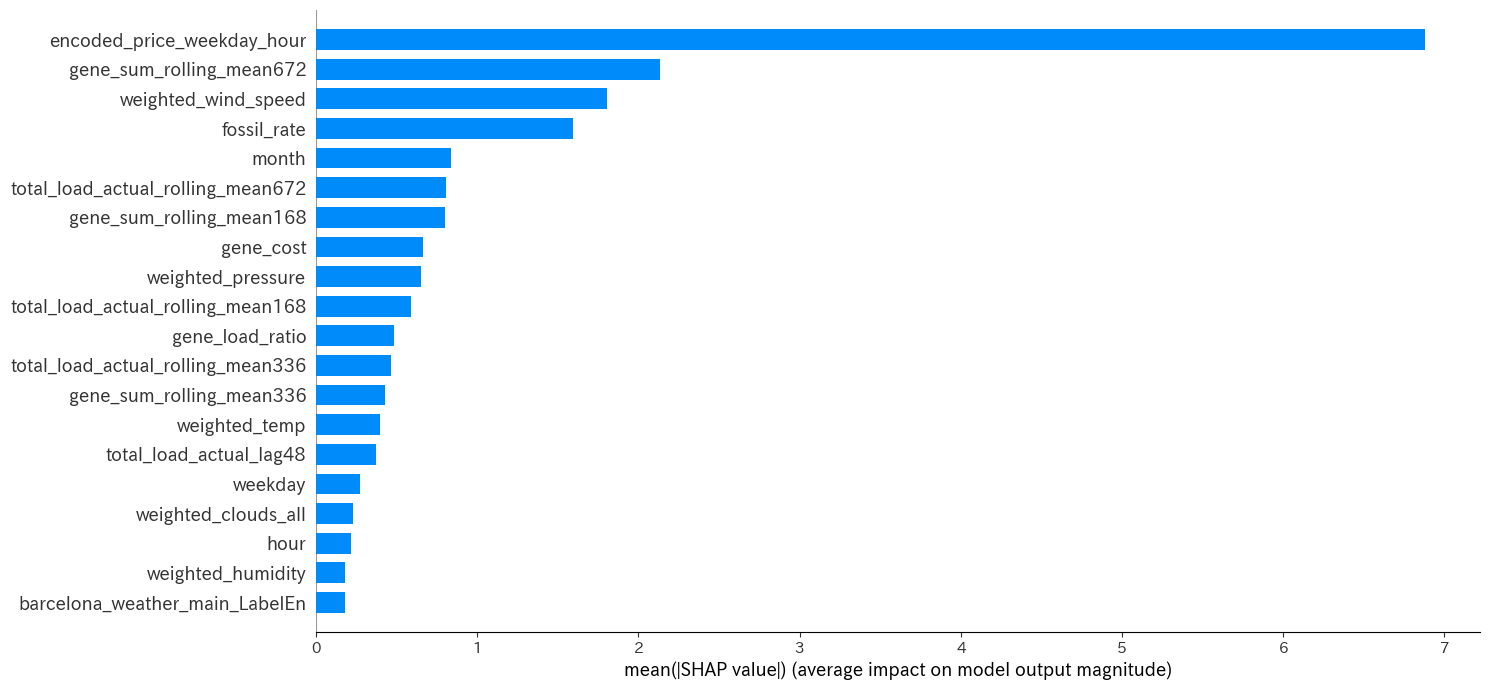

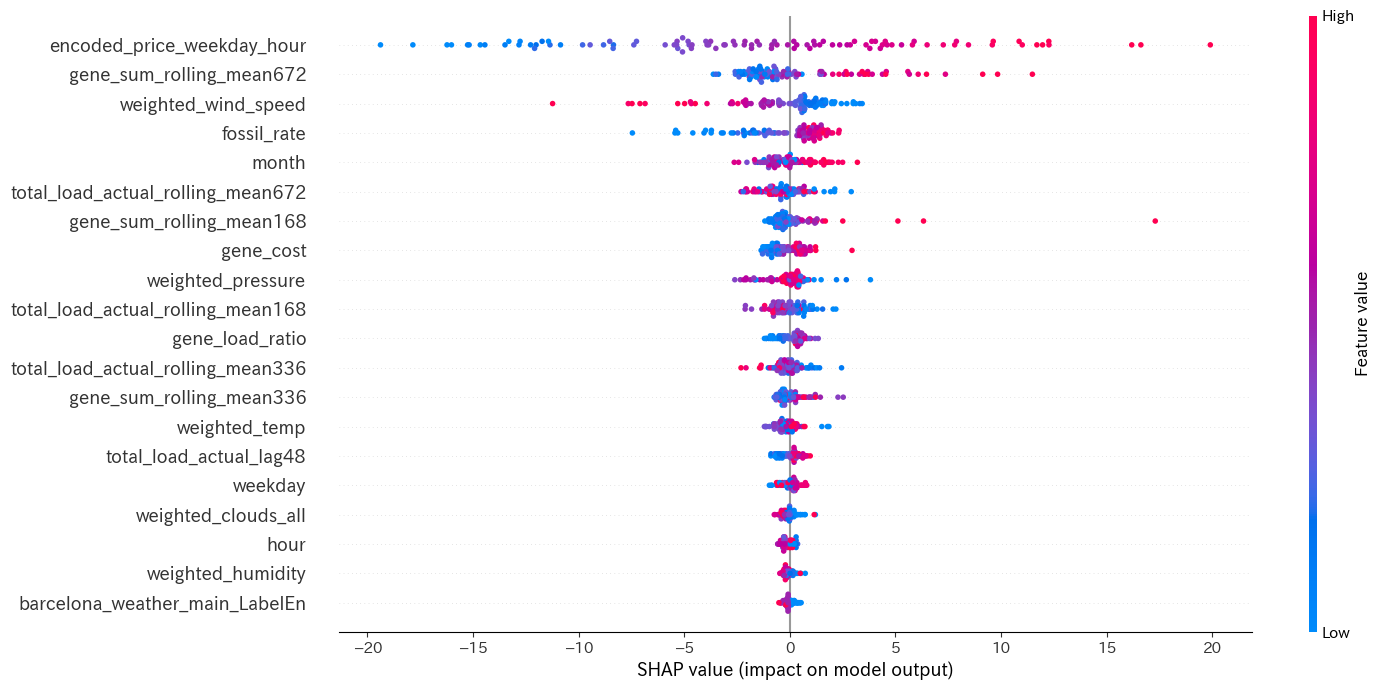

In [14]:
# 特徴量重要度の可視化
shap.summary_plot(shap_values, shap_sample, plot_type='bar', plot_size=(15, 7))
shap.summary_plot(shap_values, shap_sample, plot_size=(15, 7))

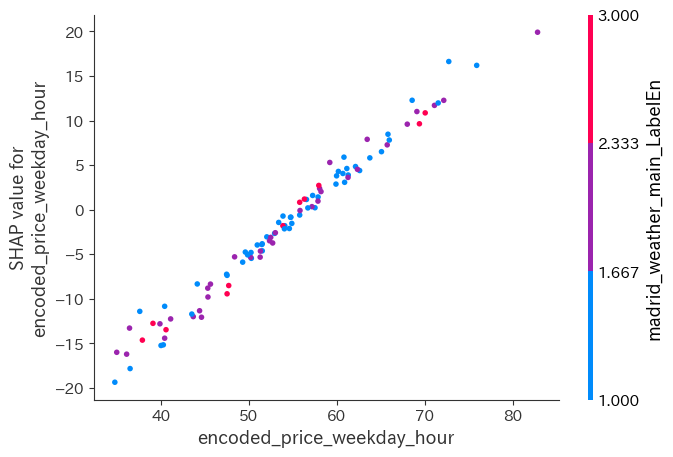

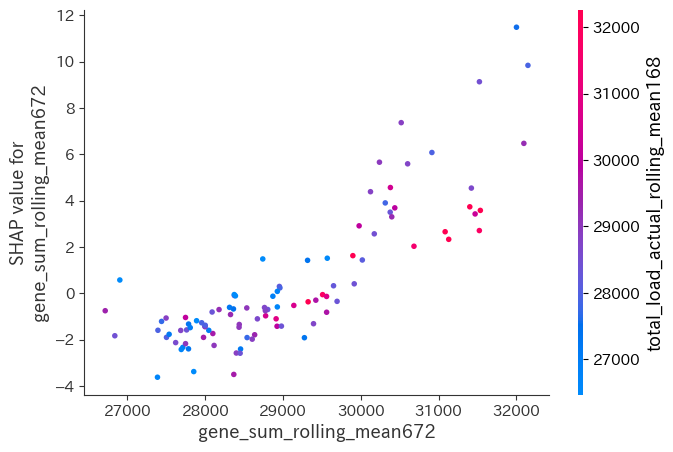

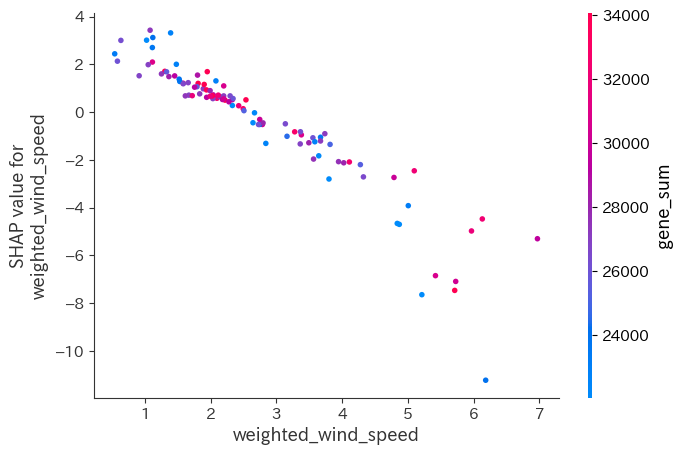

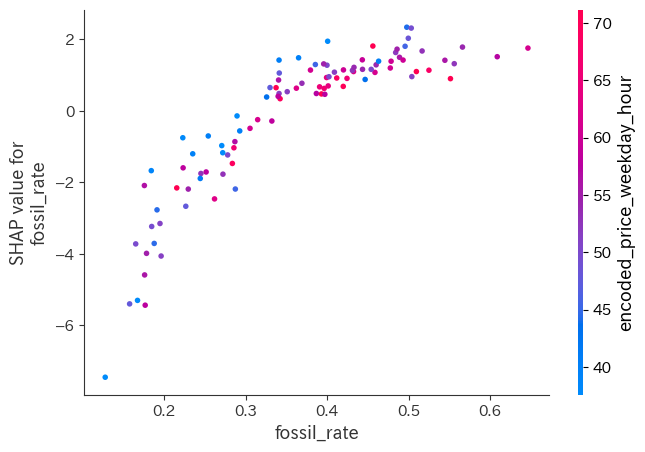

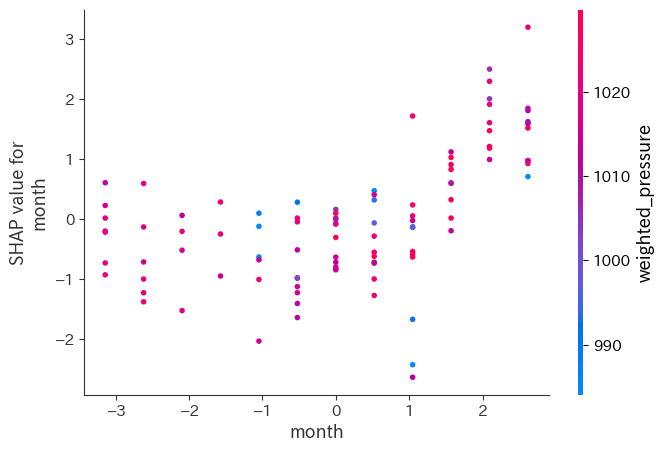

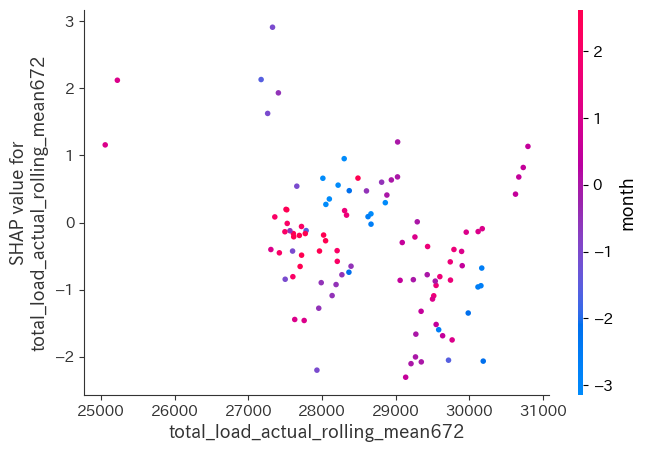

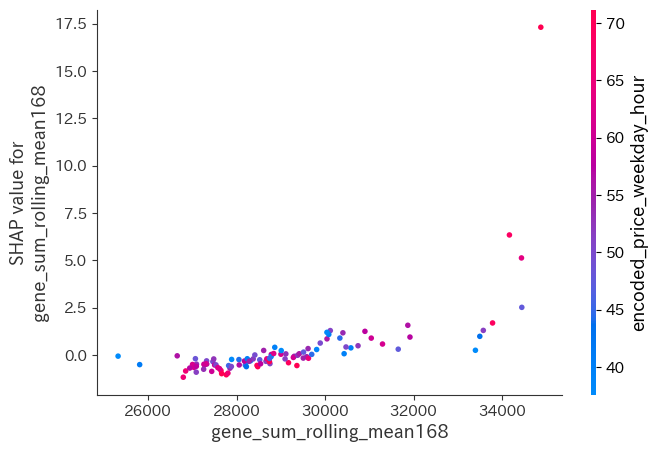

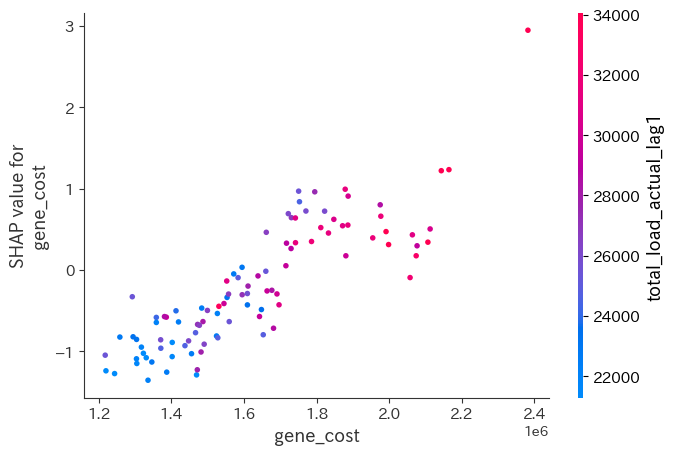

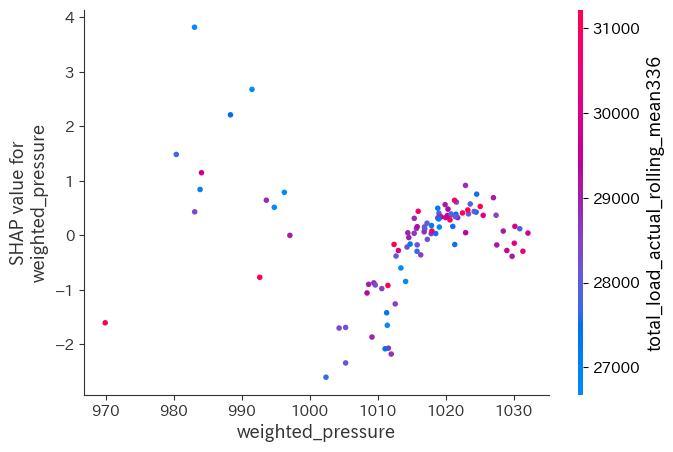

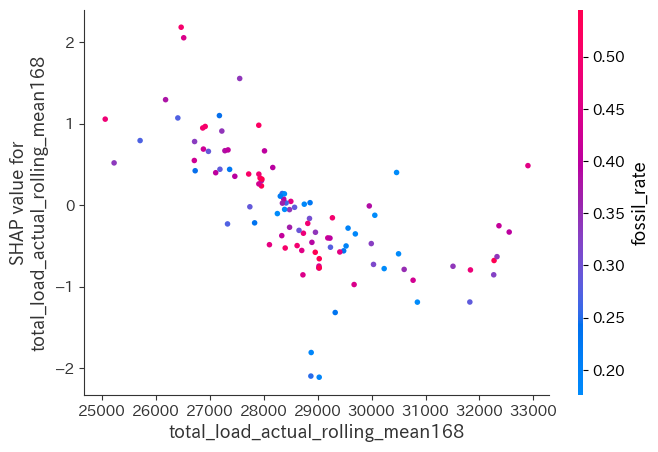

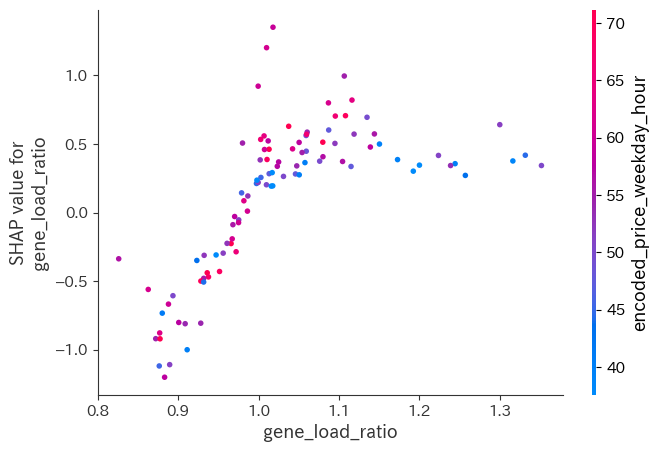

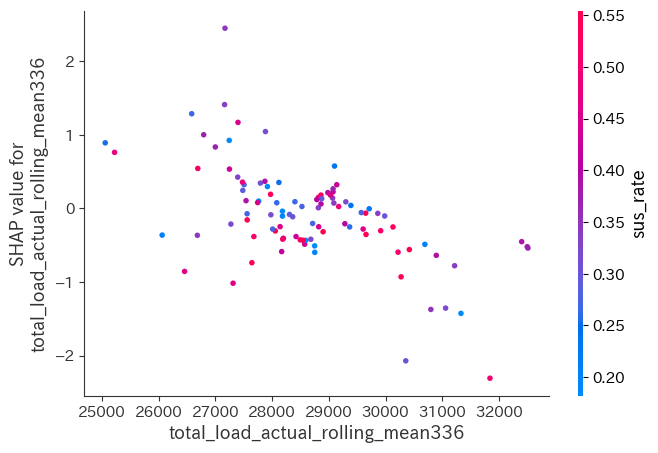

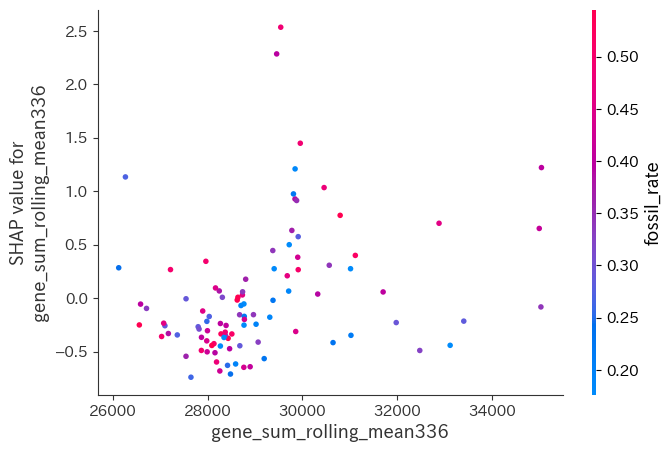

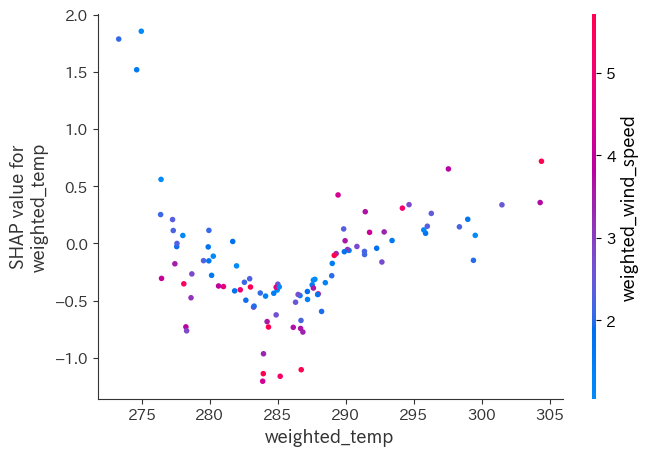

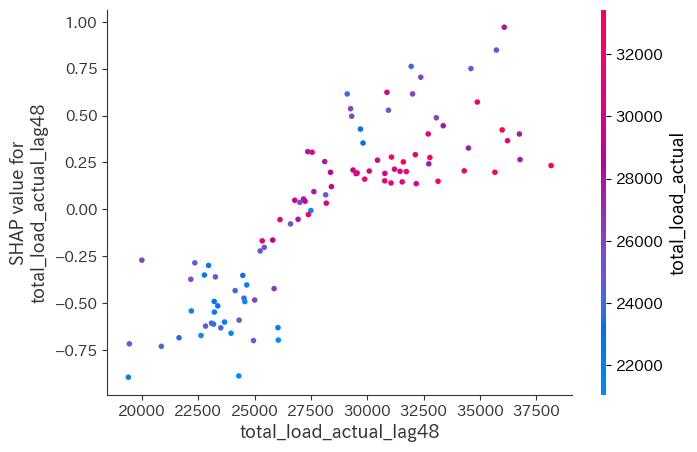

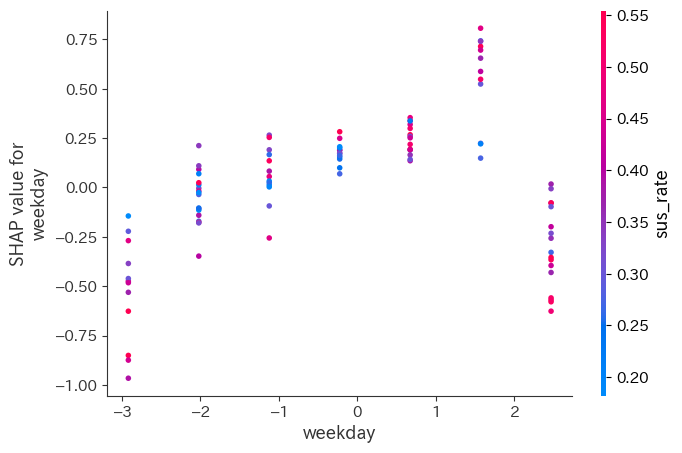

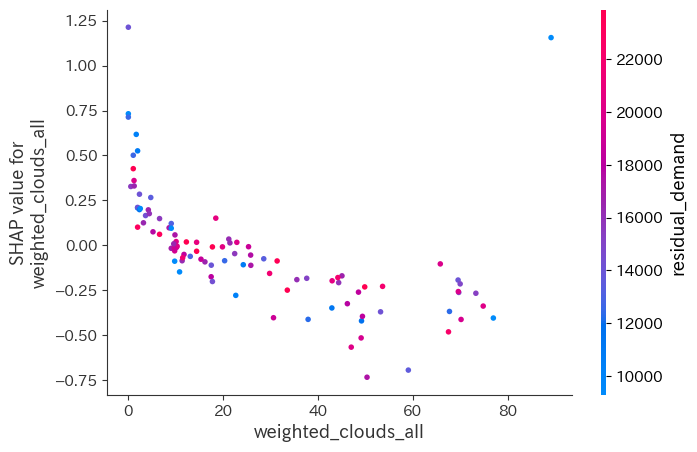

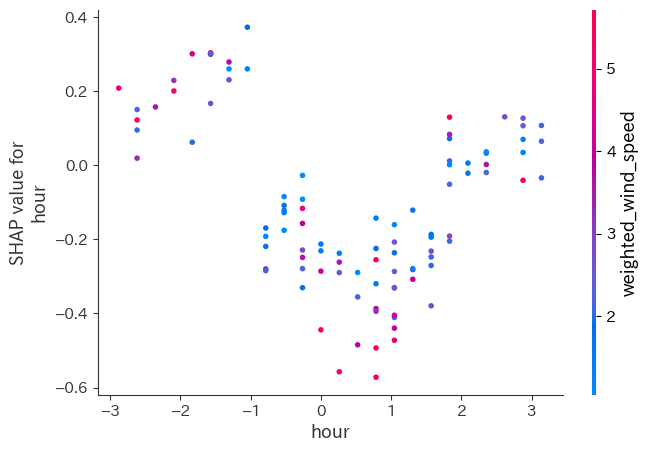

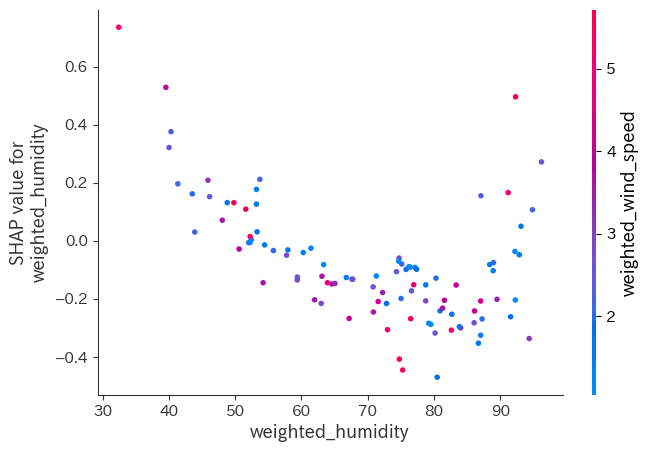

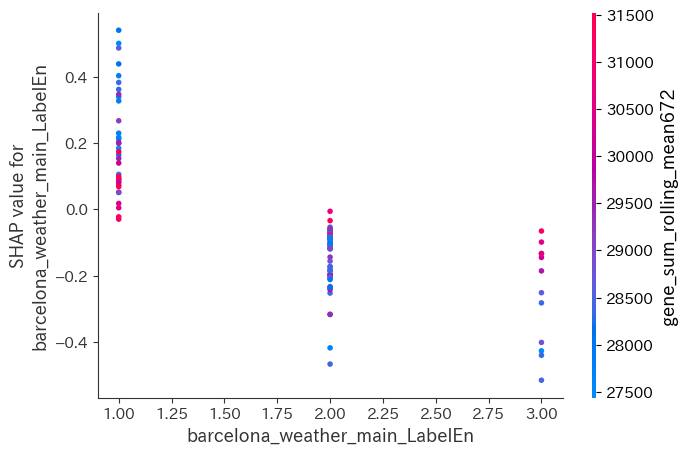

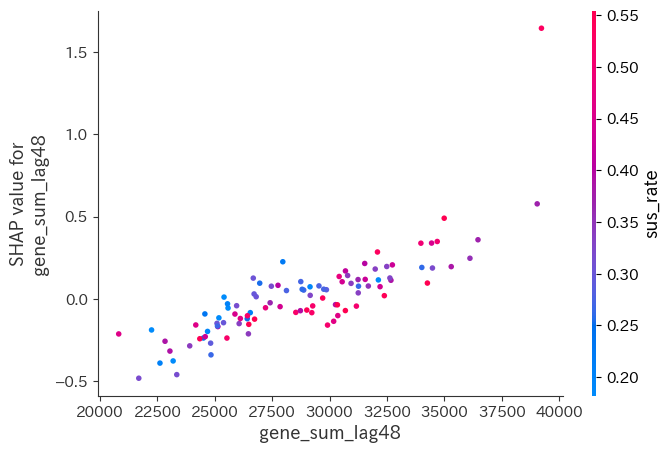

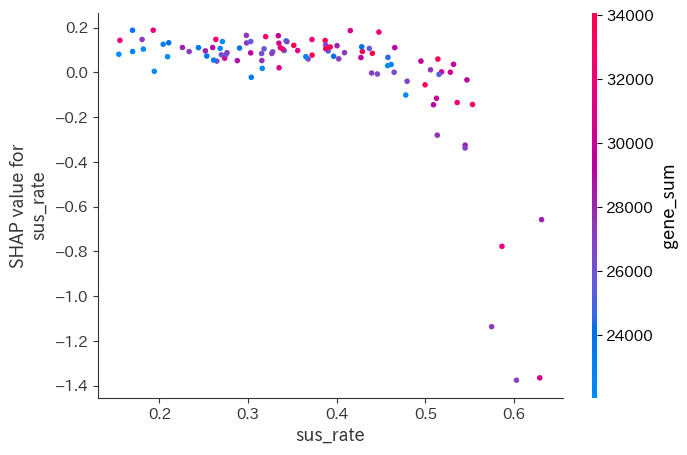

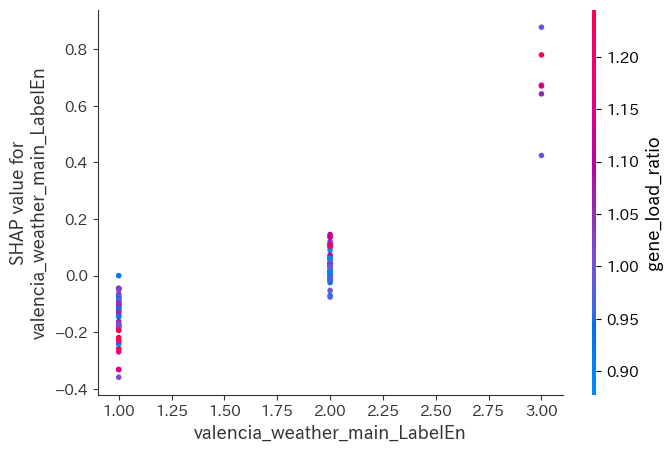

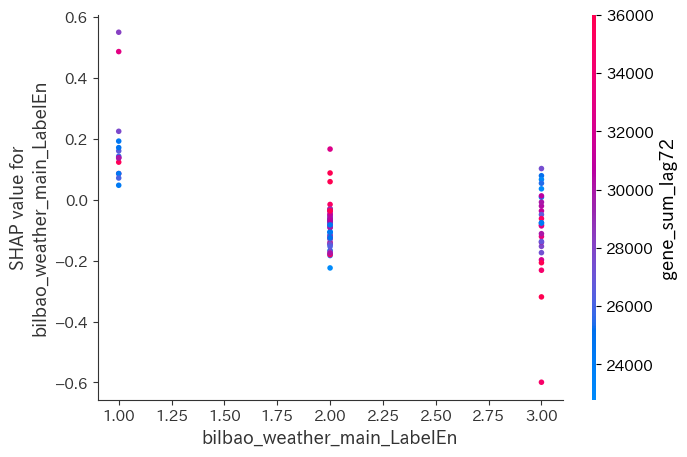

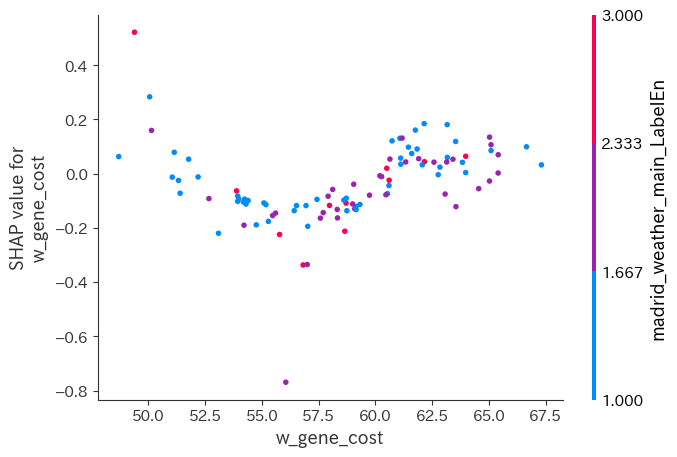

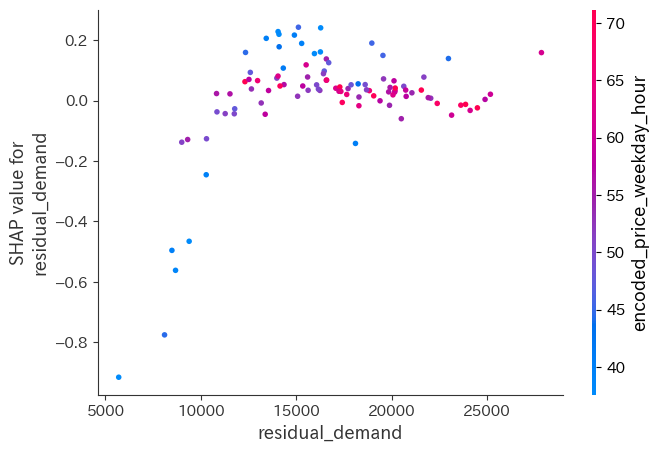

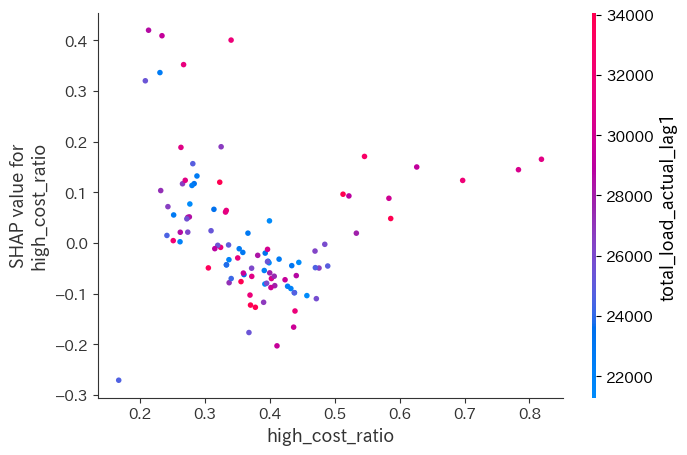

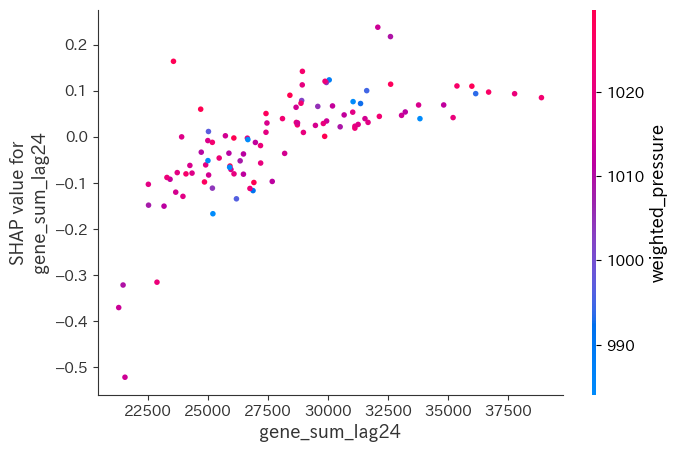

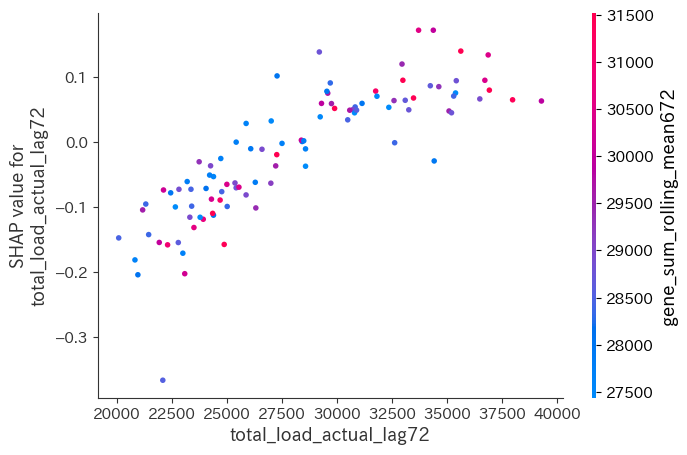

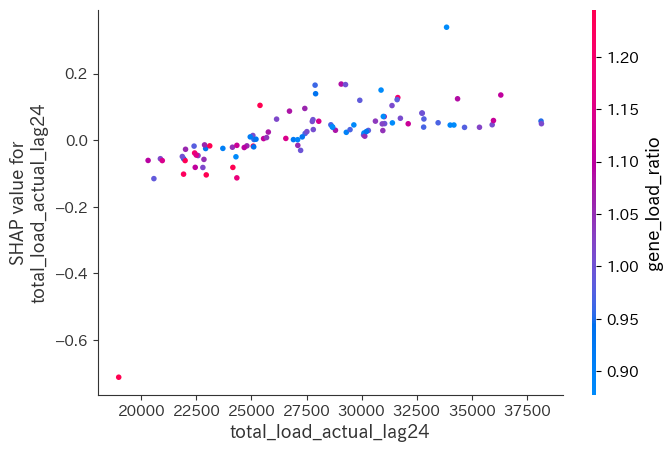

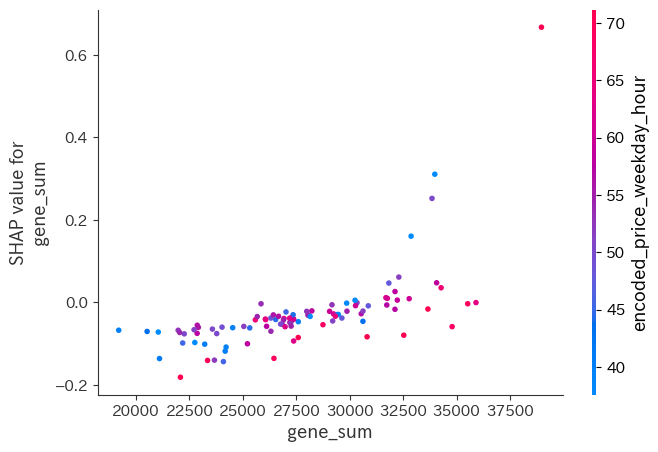

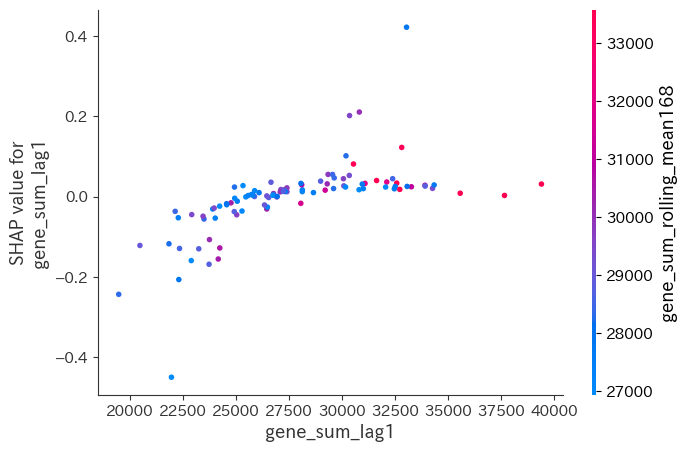

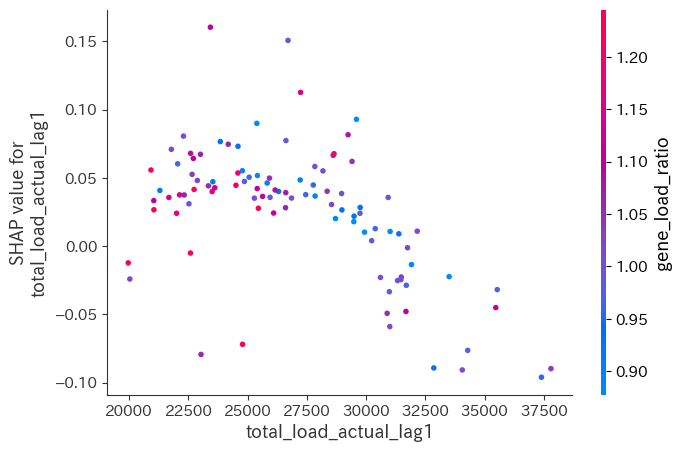

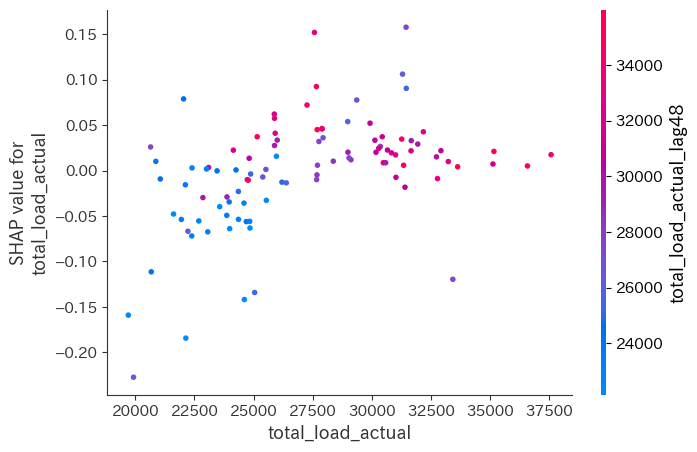

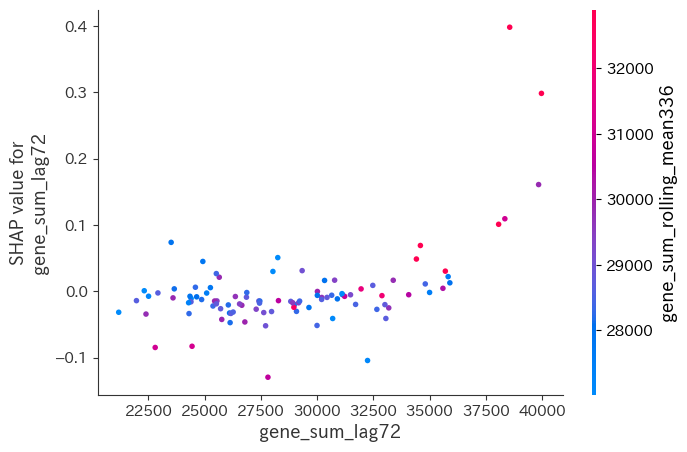

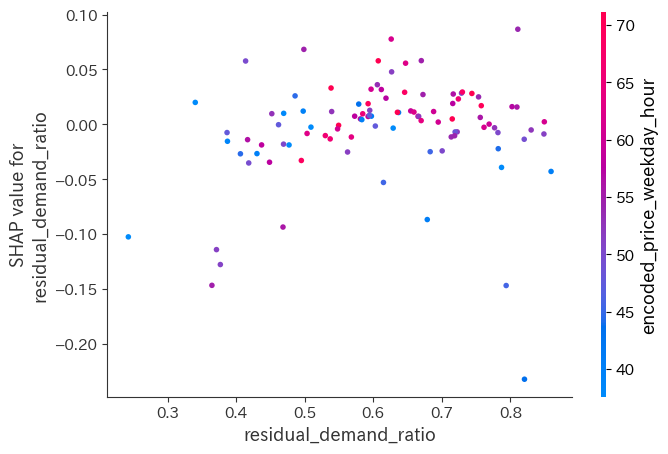

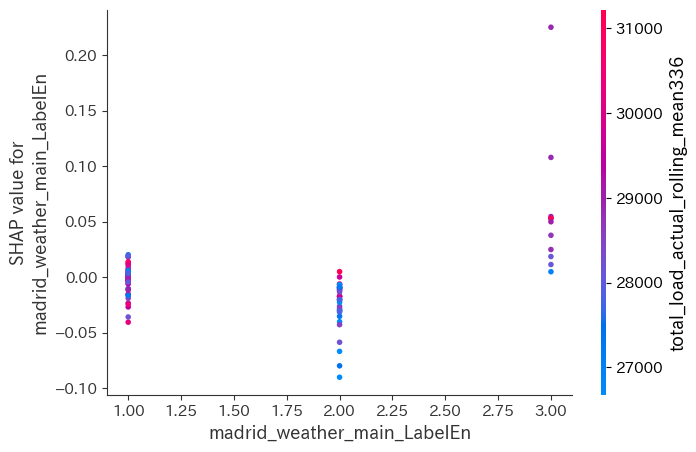

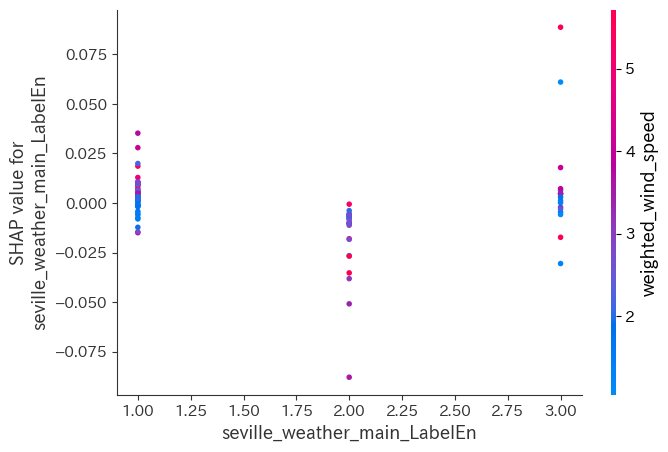

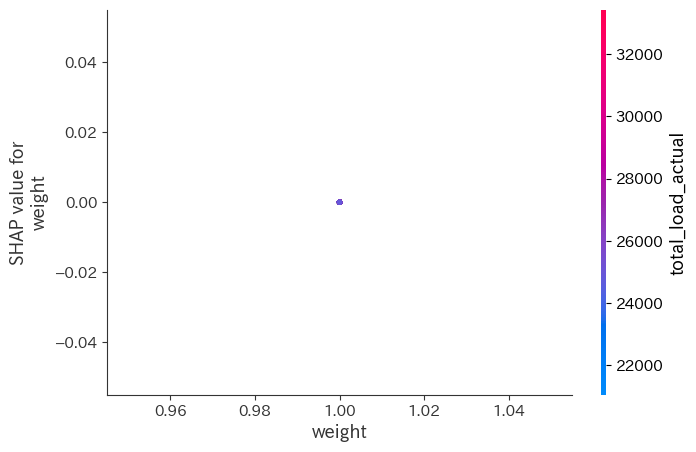

In [15]:
# 特徴量値の変化に応じた変化を描画
for feature in shap_importance['特徴量']:
    shap.dependence_plot(feature, shap_values, shap_sample)

#### 特徴量の作用

In [16]:
# スケーリングされた値を元のスケールに戻す関数
def _inverse_scale(values, feature_name, scaler_params_path):
    scaler_df = pd.read_csv(scaler_params_path, encoding='utf-8-sig')
    row = scaler_df[scaler_df['特徴量名'] == feature_name]

    if row.empty:
        print(f'スケーリング情報が見つかりません: {feature_name}')
        return values
    
    method = row.iloc[0]['手法']

    if method == 'std':
        mean = row.iloc[0]['mean']
        std = row.iloc[0]['std']
        return values * std + mean
    

# 学習時の特徴量のリストを取得する
def _get_model_features_for_pdp(model):
    if isinstance(model, lgb.Booster):
        return model.feature_name()
    else:
        return None


# PDPを描画する関数
def _drew_pdp(df, model_features, feature_name, pred_func, title_suffix='', num_grid_points=50, scaler_param_path=None):
    pdp_isolated = pdp.PDPIsolate(
        model=None if pred_func else model,
        df=df[model_features],
        model_features=model_features,
        feature=feature_name,
        feature_name=feature_name,
        n_classes=0,
        num_grid_points=num_grid_points,
        pred_func=pred_func
    )

    x_vals = pdp_isolated.feature_info.grids
    y_vals = pdp_isolated.results[0].pdp

    # スケーリングを元に戻す
    if scaler_param_path is not None:
        x_vals = _inverse_scale(x_vals, feature_name, scaler_param_path)
    
    plt.figure(figsize=(10, 5))
    plt.plot(x_vals, y_vals, marker='o', linestyle='-')
    plt.xlabel(feature_name)
    plt.ylabel('予測値')
    plt.title(f'特徴量の作用: {feature_name}_{title_suffix}')
    plt.grid(True)
    plt.show()


# 単一モデルに対してPDPを実施する関数
def plot_pdp(model, features, top10_feature_list, model_name='', num_grid_points=50, scaler_param_path=None):
    model_features = _get_model_features_for_pdp(model)

    def pred_func(_, X):
        if isinstance(model, lgb.Booster):
            return model.predict(pd.DataFrame(X, columns=model_features))
        
    for top_feature in top10_feature_list:
        _drew_pdp(
            features,
            model_features,
            top_feature,
            pred_func,
            title_suffix=model_name,
            num_grid_points=num_grid_points,
            scaler_param_path=scaler_param_path
        )

using provided pred_func.


100%|██████████| 149/149 [00:00<00:00, 1359.23it/s]


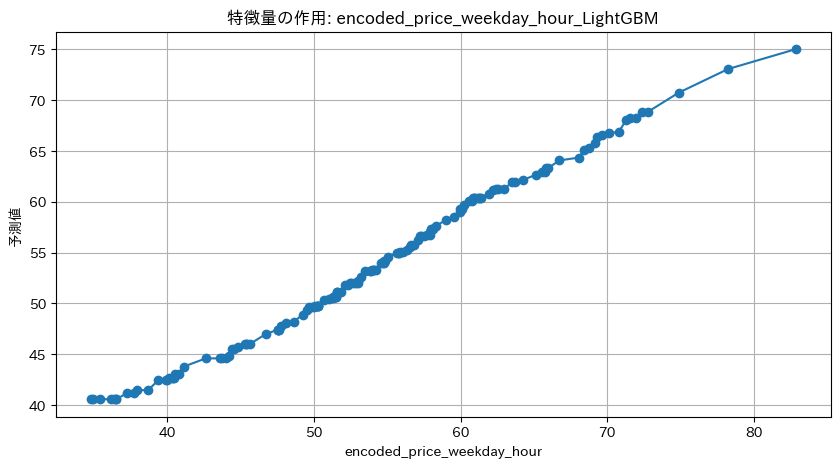

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 679.68it/s]


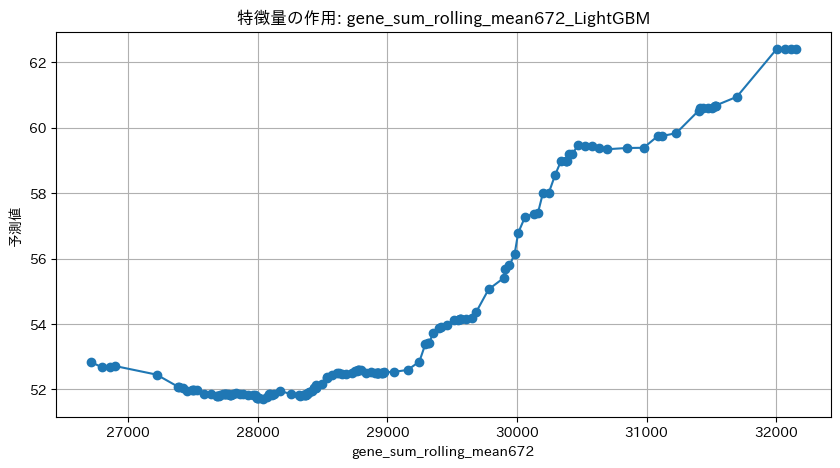

using provided pred_func.


100%|██████████| 148/148 [00:00<00:00, 1098.56it/s]


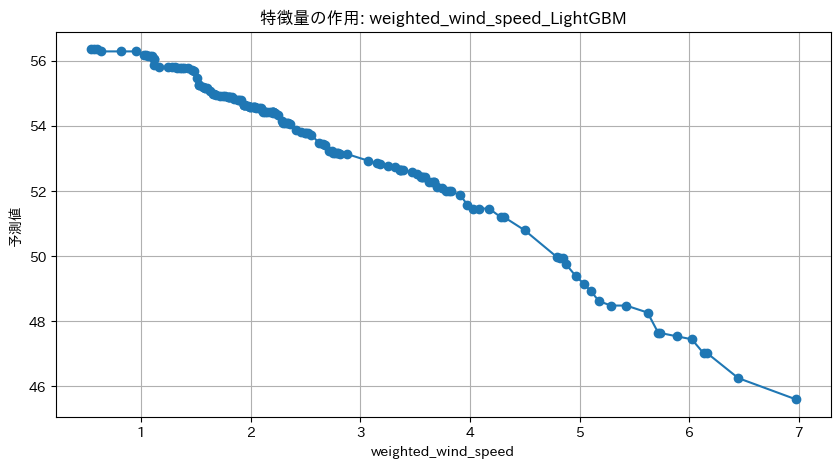

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 763.08it/s]


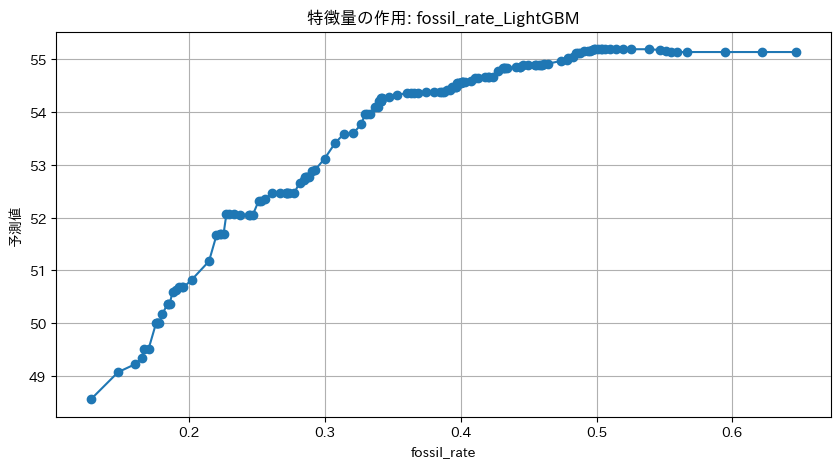

using provided pred_func.


100%|██████████| 28/28 [00:00<00:00, 1171.11it/s]


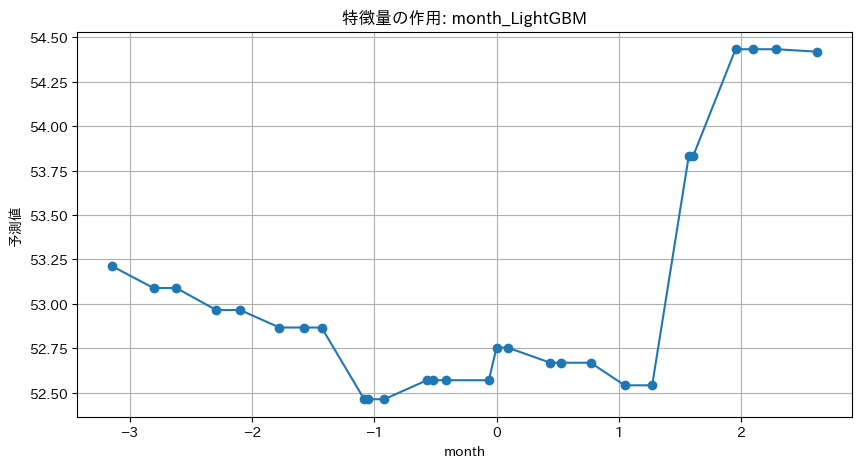

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 1264.49it/s]


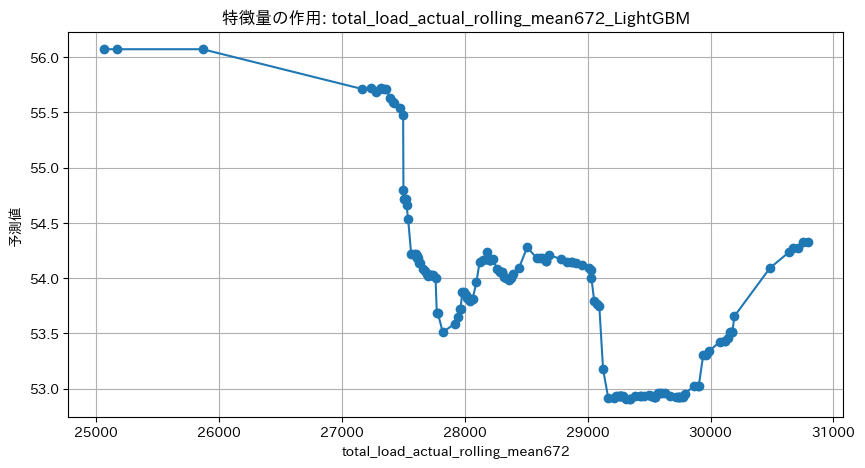

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 1234.55it/s]


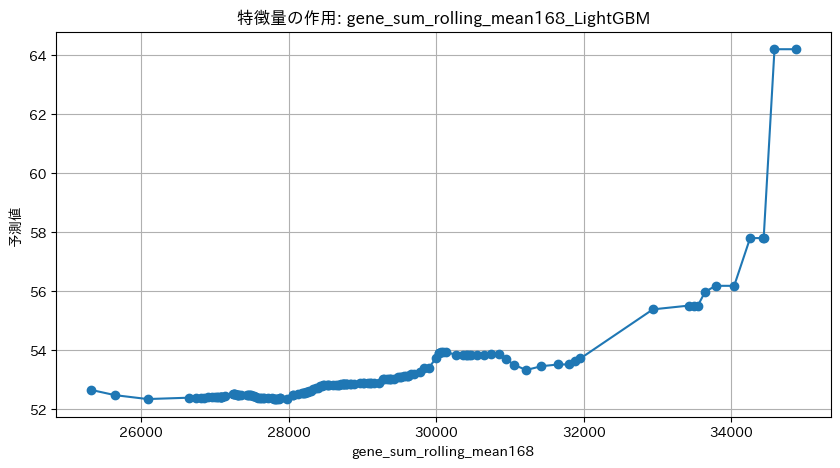

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 1241.47it/s]


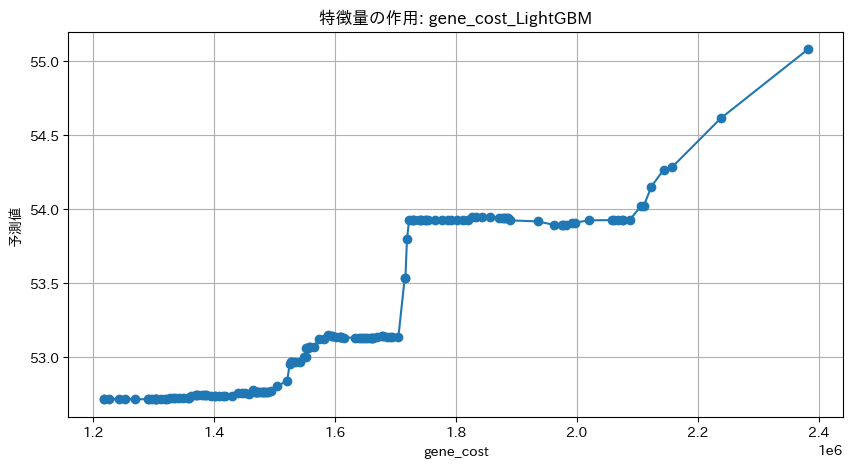

using provided pred_func.


100%|██████████| 149/149 [00:00<00:00, 1225.23it/s]


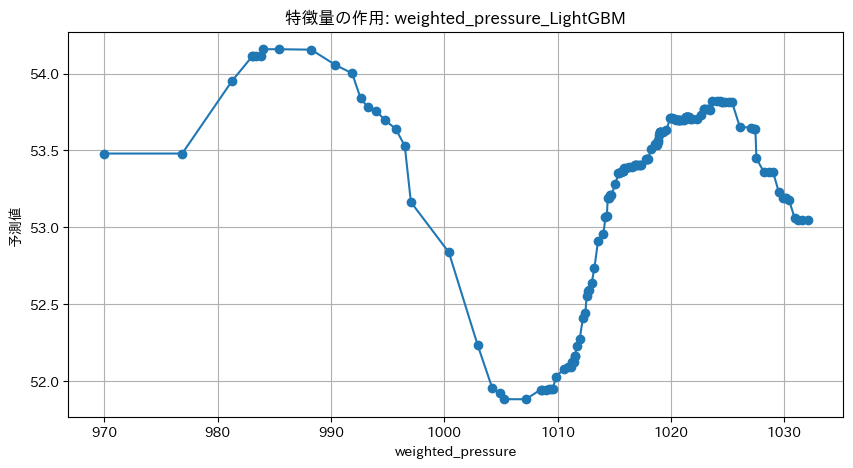

using provided pred_func.


100%|██████████| 150/150 [00:00<00:00, 1258.85it/s]


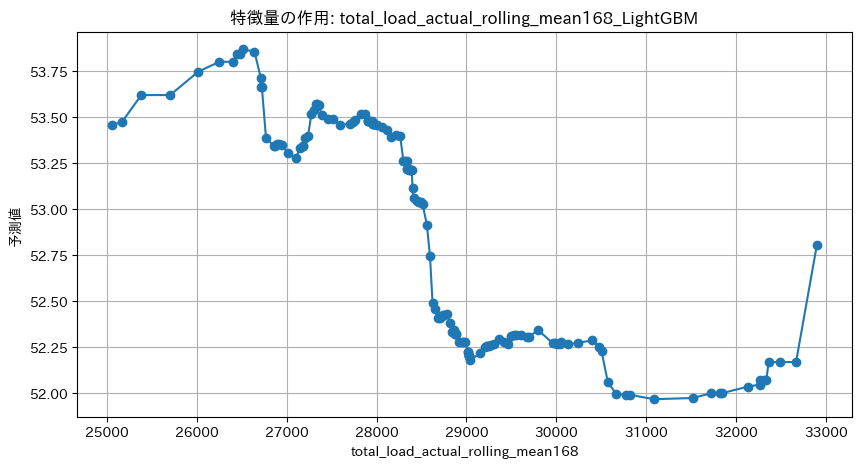

In [17]:
top10_list = shap_importance.iloc[0:10, 0].to_list()
plot_pdp(final_model, shap_sample, top10_list, 'LightGBM', num_grid_points=150, scaler_param_path=None)